In [1]:
import networkx as nx
import math
import random

import numpy as np

import torch
from torch import optim

import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


In [53]:
def procrustes(x,y):
    u,s,vt = np.linalg.svd(x.T @ y)
    return u @ vt

def centralize(x):
    return x - x.mean(0)

def automorphism(G, index2id, id2index):
    indices = [index2id[x] for x in G.nodes]
    indices = [(i+1)%len(G) for i in indices]
    order = len(G)
    score = 1
#     random.shuffle(indices)
#     adj0 = nx.adjacency_matrix(G).todense()
#     adj = adj0[indices]
#     adj = adj[:,indices]
#     score = (adj*adj0).sum() / (adj + adj0).sum()
    return indices, order, score


def rotation(angle):
    c,s = math.cos(angle), math.sin(angle)
    return torch.tensor([
        [c, s],
        [-s, c]
    ])

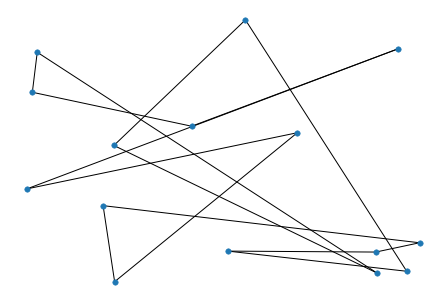

In [54]:
G = nx.cycle_graph(15)
n = len(G.nodes())
id2index = {node_id: i for i, node_id in enumerate(G.nodes)}
index2id = {v: k for k,v in id2index.items()}

pos0 = nx.random_layout(G)
# pos0 = nx.spring_layout(G)

nx.draw(G, pos=pos0, node_size=30)
plt.show()

In [55]:
pos = np.array([pos0[node_id] for node_id in G], dtype=np.float32)
pos = torch.from_numpy(pos)
pos.requires_grad_(True)

niter = 10000
optimizer = optim.SGD([pos], lr=0.01, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-6, 1e-2, step_size_up=int(niter/10), step_size_down=int(niter/10*9))
epochBar = tqdm(range(niter))

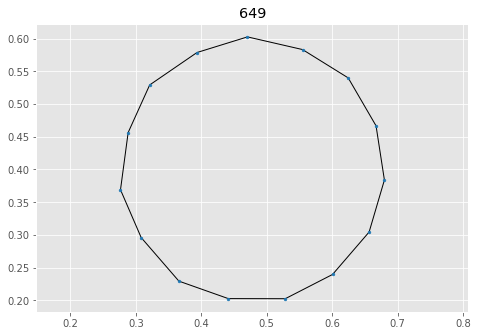

KeyboardInterrupt: 

In [56]:

for i in epochBar:
    
    auto, order, weight = automorphism(G, index2id, id2index)
    pos1 = pos[auto]
    
    with torch.no_grad():
        Q = procrustes(centralize(pos1), centralize(pos))
        Q = torch.from_numpy(Q)
        Q = rotation(2*np.pi/order)
    loss = weight * torch.norm(centralize(pos)-centralize(pos1)@Q)
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i % 50 == 49:
        with torch.no_grad():
            display.clear_output(wait=True)
            nx.draw(G, pos={index2id[i]:p.detach().numpy() for i, p in enumerate(pos)}, node_size=8)
            plt.axis('equal')
            plt.axis('on')
            plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#             plt.scatter(pos[:,0].detach(), pos[:,1].detach())
            plt.title(i)
            plt.show()
    
# display.clear_output(wait=True)
# nx.draw(G, pos={index2id[i]:p.detach().numpy() for i, p in enumerate(pos)}, node_size=30)
# plt.scatter(crossings[:,0].detach(), crossings[:,1].detach(), c='C1', s=10)
# plt.title(i)
# plt.show()

In [ ]:
pos1@

---